# Simulation Notebook

In [41]:
from agents import *
from environment import *
from IPython.display import clear_output 
import time
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('font', size = 20)
plt.rc('text', usetex=True)


# Configuration

In [2]:
# Numbers
hv = 500        # n of HVs
av = 500         # n of AVs
N = 500           # n of Days

# Human Parameters
hv_err = 5        # error term on HV time perception ~N(0, hv_err)
hv_theta = .5     # rationality
hv_beta = .5     # prob of change route
hv_len = 3        # Memory lenth
hv_atis_bais = 0  # bias*prevTT + (1-bais)*memTT

# AV Parameters
av_err = 0
av_theta = 1
av_len = 1000     
av_atis_bias = 0
# no beta. all routes always concidered

orig = '1'
dest = '9'

# Save Data
route_dir = f"data/sim-ROUTES-N{N}-hv{hv}at{hv_err}_{hv_theta}_{hv_beta}_{hv_len}_{hv_atis_bais}-av{av}at{av_err}_{av_theta}_{av_len}_{av_atis_bias}.pickle"
roads_dir = f"data/sim-ROADS-N{N}-hv{hv}at{hv_err}_{hv_theta}_{hv_beta}_{hv_len}_{hv_atis_bais}-av{av}at{av_err}_{av_theta}_{av_len}_{av_atis_bias}.pickle"

# Define Roads
roads = [Road('1', '2', 720, 20), Road('2', '3', 720, 12), Road('1', '4', 480, 15), Road('2', '5', 360, 12),
	Road('3', '6', 720, 12), Road('4', '5', 300, 10), Road('5', '6', 360, 12), Road('4', '7', 480, 15),
	Road('5', '8', 300, 10), Road('6', '9', 720, 30), Road('7', '8', 480, 15) ,Road('8', '9', 480, 15)]

# Constuct Model

In [3]:
network = Network(roads)
network.display()

,Road,Origin,Destination,Capacity,Free Flow,Count,TT
0,Road(1->2),1,2,720,20,0,20.0
1,Road(2->3),2,3,720,12,0,12.0
2,Road(1->4),1,4,480,15,0,15.0
3,Road(2->5),2,5,360,12,0,12.0
4,Road(3->6),3,6,720,12,0,12.0
5,Road(4->5),4,5,300,10,0,10.0
6,Road(5->6),5,6,360,12,0,12.0
7,Road(4->7),4,7,480,15,0,15.0
8,Road(5->8),5,8,300,10,0,10.0
9,Road(6->9),6,9,720,30,0,30.0


In [4]:
drivers = [HV(orig, dest, err = hv_err, theta = hv_theta, beta = hv_beta, L = hv_len) for i in range(0, hv)]
if av > 0:
    drivers = drivers + [AV(orig, dest, theta = av_theta, err = av_err, L = av_len, atis_bias = av_atis_bias) for i in range(0, av)]

# Day 1

In [5]:
%%time
for driver in drivers:
    driver.learn(network)
drivers[0].display()

Last route: route 5:[Road(1->4), Road(4->7), Road(7->8), Road(8->9)]
Wall time: 116 ms


,Road,Memory,ETT
0,Road(1->2),[75.94076088802527],75.940761
1,Road(2->3),[-14.04279271765662],-14.042793
2,Road(1->4),[23.796495680990937],23.796496
3,Road(2->5),[28.27892965452398],28.278930
4,Road(3->6),[7.091099968074674],7.091100
5,Road(4->5),[68.95763824578091],68.957638
6,Road(5->6),[81.59025003070929],81.590250
7,Road(4->7),[-20.206601611177668],-20.206602
8,Road(5->8),[113.02295624524449],113.022956
9,Road(6->9),[94.32283374447375],94.322834


In [6]:
network.update(drivers)
network.display()

,Road,Origin,Destination,Capacity,Free Flow,Count,TT
0,Road(1->2),1,2,720,20,206,20.153585
1,Road(2->3),2,3,720,12,72,12.001380
2,Road(1->4),1,4,480,15,794,94.902229
3,Road(2->5),2,5,360,12,134,12.263483
4,Road(3->6),3,6,720,12,72,12.001380
5,Road(4->5),4,5,300,10,683,185.775694
6,Road(5->6),5,6,360,12,107,12.107697
7,Road(4->7),4,7,480,15,111,15.049331
8,Road(5->8),5,8,300,10,710,219.787486
9,Road(6->9),6,9,720,30,179,30.131796


In [7]:
# Logs
time_log = pd.DataFrame(columns = [f'Road{i}' for i in range(len(network.roadlist))])
time_log.loc[0] = [road.tt(network) for road in network.roadlist]

route_log = pd.DataFrame(columns = [f'Route{i}' for i in range(len(drivers[0].routes))])
route_count = [0 for route in range(len(drivers[0].routes))]
for driver in drivers:
    route_count[driver.i] = route_count[driver.i] + 1
route_log.loc[0] = route_count
route_log

,Route0,Route1,Route2,Route3,Route4,Route5
0,72,45,89,62,621,111


# Day >1

In [13]:
%%time
for i in range(1,N):
    
    start = time.time()   
    for driver in drivers:
        driver.drive(network)
    network.update(drivers)
    
    time_log.loc[i] = [road.tt(network) for road in network.roadlist]
    route_count = [0 for route in route_log.keys()]
    for driver in drivers:
        route_count[driver.i] = route_count[driver.i] + 1
    route_log.loc[i] = route_count
    end = time.time()
    
    # Timing and ETA
    dif = end - start
    togo = N - i
    left = dif * togo
    mins = int(left//60)
    secs = int(left - mins*60)
    perc = int(100*i/N)
    clear_output(wait=True) # WIP indicator
    print(f"Day {i}/{N} : {perc}% : ETA {mins}:{secs}")
clear_output(wait=True)
route_log.tail()

Wall time: 48.7 s


,Route0,Route1,Route2,Route3,Route4,Route5
495,356,119,105,72,151,197
496,301,86,133,63,189,228
497,324,142,103,84,164,183
498,264,105,118,57,199,257
499,299,148,115,60,154,224


In [50]:
pickle.dump(route_log, open(route_dir, "wb" ))
#pickle.dump(count_log, open(roads_dir, "wb" ))

In [14]:
{network.routes('1','9').index(route) : route for route in network.routes('1','9')}

{0: [Road(1->2), Road(2->3), Road(3->6), Road(6->9)],
 1: [Road(1->2), Road(2->5), Road(5->6), Road(6->9)],
 2: [Road(1->2), Road(2->5), Road(5->8), Road(8->9)],
 3: [Road(1->4), Road(4->5), Road(5->6), Road(6->9)],
 4: [Road(1->4), Road(4->5), Road(5->8), Road(8->9)],
 5: [Road(1->4), Road(4->7), Road(7->8), Road(8->9)]}

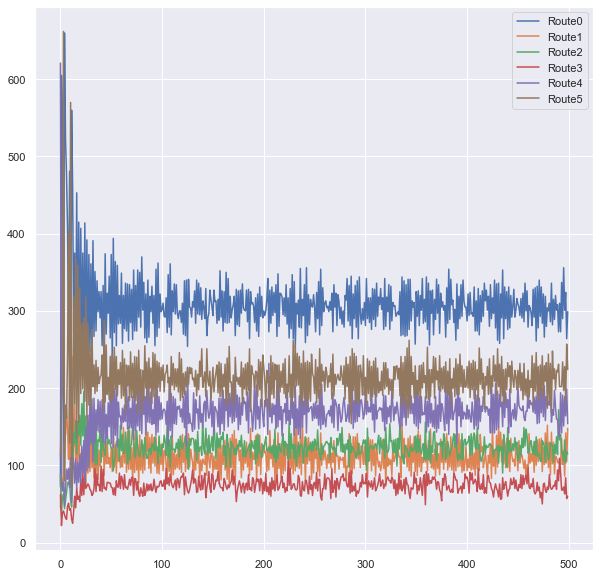

In [15]:
route_log.plot(figsize=(10,10))

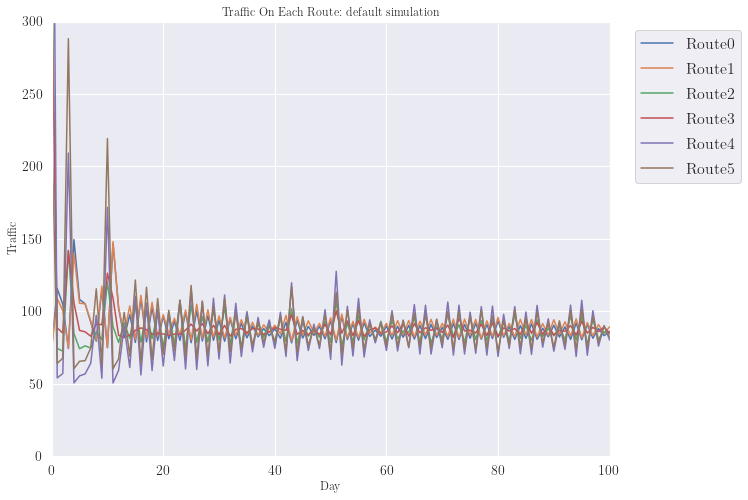

In [49]:
routes = network.routes('1','9')
time_routes = pd.DataFrame(columns = [f'Route{i}' for i in range(len(drivers[0].routes))])
for i in range(500):
    ttr = []
    for route in routes:
        tt = 0
        for road in route:
            tt = tt + time_log[f"Road{network.roadlist.index(road)}"][i]
        ttr.append(tt)
    time_routes.loc[i] = ttr

times_dir = f"data/sim-TIMES-N{N}-hv{hv}at{hv_err}_{hv_theta}_{hv_beta}_{hv_len}_{hv_atis_bais}-av{av}at{av_err}_{av_theta}_{av_len}_{av_atis_bias}.pickle"
pickle.dump(time_routes, open(times_dir, "wb" ))

fig, ax = plt.subplots(figsize=(10,8))
ax.set(xlim=[0, 100], ylim=[0,300], xlabel='Day', ylabel='Traffic',
   title='Traffic On Each Route: default simulation  ')

# Add data
time_routes.plot(ax=ax)
ax.legend(bbox_to_anchor=(1.25, 1), fontsize=16) 
#ax.grid()



In [39]:
times_dir = f"data/sim-TIMES-N{N}-hv{hv}at{hv_err}_{hv_theta}_{hv_beta}_{hv_len}_{hv_atis_bais}-av{av}at{av_err}_{av_theta}_{av_len}_{av_atis_bias}.pickle"
pickle.dump(time_routes, open(times_dir, "wb" ))

In [46]:
sns.reset_orig

<function seaborn.rcmod.reset_orig()>